# Openpose extract pose from uploaded video

Run cells by pressing `Shift + Enter` or by clicking on the play button in the top-left corner of each cell.

The code is structured into code cells. The first cell installs Openpose on the virtual Linux machine (takes 10 minutes).


In [36]:
# Install Openpose.  Installation takes 10 minutes. Output is suppressed with (%%capture).
%%capture  
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

In [37]:
# Upload videos (If too slow, its also possible to mount data from a Google Drive)
from google.colab import files

# Delete any existing videos, plots, and data
!rm -f *.mp4 *.csv *.json *.png

# Upload to current directory
uploaded_dict = files.upload()
filename = list(uploaded_dict.keys())[0]

# Rename the uploaded file 
!mv *.mp4 video.mp4

Saving yc_cmjt1_42.0.mp4 to yc_cmjt1_42.0.mp4


In [38]:
# Run OpenPose on the video. %%capture suppresses output
%%capture  
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ../ --display 0  --write_video ../output.mp4 --number_people_max 1

In [39]:
# Read in all body pose keypoints from OpenPose
import pandas as pd
import glob
import json

# Extract frames from json
frame_files = sorted(glob.glob('*.json'))

# Initiate empty data frame
keypoint_dataframe = pd.DataFrame()

# Iterate over frames/files
for frame in frame_files:
  
  # Its a nested json file. keypoints are recorded for each `people`
  df = pd.read_json(frame)
  people_json = df.people.to_json()
  features = pd.read_json(people_json)
  keypoints = features.loc['pose_keypoints_2d', :]
  
  # The keypoints are saved as a list into the first row of the pandas series...
  # The standard OpenPose model saves 25 body points as x,y,z pixel coordinates
  # Therefore, the pose_keypoints_2d are a set of 25*3 = 75 data points.

  # Take the list and make it into a data frame (rows, columns)
  keypoints_rows = pd.DataFrame(keypoints[0]).T

  # Append each frame, resulting in a (frames x 75 columns) data frame
  keypoint_dataframe = pd.concat([keypoint_dataframe, keypoints_rows])

  # Create a new row index
  keypoint_dataframe.reset_index(drop=True, inplace=True)

In [40]:
#@title Input your height from ankle to knee [cm]
participant_ankle_knee_height_cm = 35 #@param {type:"integer"}

In [54]:
# Read in the right markers
from enum import Enum

class Dimension(Enum):
  x = 0
  y = 1
  z = 2
  size = 3

class Body25Markerset(Enum):
  # The markers are documented here: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#pose-output-format-body_25
  right_ankle = 11
  right_knee = 10
  mid_hip = 8

right_ankle_y = (Body25Markerset.right_ankle.value * Dimension.size.value) + Dimension.y.value
right_knee_y = (Body25Markerset.right_knee.value * Dimension.size.value) + Dimension.y.value
mid_hip_y = (Body25Markerset.mid_hip.value * Dimension.size.value) + Dimension.y.value

initial_frames = 10
initial_pos_right_ankle_y = keypoint_dataframe.iloc[:initial_frames, right_ankle_y].mean()
initial_pos_right_knee_y = keypoint_dataframe.iloc[:initial_frames, right_knee_y].mean()
initial_pos_mid_hip_y = keypoint_dataframe.iloc[:initial_frames, mid_hip_y].mean()
maximal_pos_mid_hip_y = keypoint_dataframe.iloc[:, mid_hip_y].min()

0     71.215702
1     71.223792
2     71.222487
3     71.210483
4     71.214136
        ...    
74    71.251716
75    71.261111
76    71.259023
77    71.261372
78    71.241016
Name: 25, Length: 79, dtype: float64
Scaling factor for participant (pixel/cm) is: 3.8


In [60]:
# Scale from pixel to cm
ankle_knee_height_px =  initial_pos_right_knee_y - initial_pos_right_ankle_y
pixel_cm_scale = abs(ankle_knee_height_px / participant_ankle_knee_height_cm);
print(f"Scaling factor for participant (pixel/cm) is: {pixel_cm_scale:.1f}")

# Converting the height from the feet to the hip from pixel to cm
# Remember, the Y axis is inverted, thats why its a subtraction
mid_hip_px_trajectory_y = keypoint_dataframe.iloc[:,mid_hip_y]
mid_hip_cm_trajectory_y = (initial_pos_right_ankle_y - mid_hip_px_trajectory_y) / pixel_cm_scale

Scaling factor for participant (pixel/cm) is: 3.8


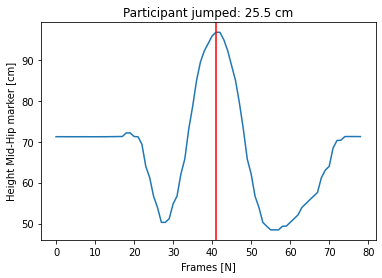

In [68]:
import matplotlib.pyplot as plt

# Plot hip trajectory and jump height
plt.plot(mid_hip_cm_trajectory_y)

# Plot maximal height line
plt.axvline(hip_y.index[hip_y == maximal_pos_mid_hip_y], color = 'red')

# How hight did the participant jump?
vertical_height_px = initial_pos_mid_hip_y - maximal_pos_mid_hip_y
vertical_height_cm = vertical_height_px / pixel_cm_scale

# Axis
plt.title(f"Participant jumped: {vertical_height_cm:.1f} cm")
plt.xlabel("Frames [N]")
plt.ylabel("Height Mid-Hip marker [cm]")

# Save the plot
plt.savefig("jumpHeight.png")

# Save the hip trajectory
mid_hip_cm_trajectory_y.to_csv("mid_hip_trajectory_y.csv", index=False)

In [69]:
# Download the video file with the overlaid body pose
files.download("output.mp4")

# Download the keyframes
files.download("mid_hip_trajectory_y.csv")

# Download the plot
files.download("jumpHeight.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>